# Overview

This notebook works through an example of deconvoluting mixed audio signals using Independent Component Analysis (ICA) in `sklearn`.  It uses the two synthetically mixed audio files generated in `generate_example_mixes.ipynb` as input.  These files were generated to simulate the recordings from two observers in a room where a piano is playing Saint-Saëns "The Carnival of the Animals - XIII" and a cello playing Bach's "Cello Suite no. 3 in C major".  In one recording, the cello is louder, but the piano can be heard in the background.  And vice versa for the other recording.  This notebook demonstrates how to deconvolute the two mixed recordings into the individual pieces with no background noise.

This notebook is a deeper exploration of an example from Udacity's [Introduction to Machine Learning with TensorFlow](https://www.udacity.com/course/intro-to-machine-learning-with-tensorflow-nanodegree--nd230).

There is also a simpler example on sklearn: [Blind source separation using FastICA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html)

In [140]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import FastICA

import wav_utils
importlib.reload(wav_utils)
from wav_utils import load_wav_file, plot_wave_arr, save_wave_arr, normalize_wav_arr, \
    build_comparison_matrix, determine_scaling_factor

## Load and plot input

Load both mixed and individual files for plotting


In [74]:
# input and output files
indiv_input_file_1 = "output/individual-clip-01.wav" # cello
indiv_input_file_2 = "output/individual-clip-02.wav" # piano

mix_input_file_1 = "output/mix-clip-01.wav" # cello louder than piano
mix_input_file_2 = "output/mix-clip-02.wav" # piano louder than cello

result_file_1 = "output/deconvoluted-signal-01.wav"
result_file_2 = "output/deconvoluted-signal-02.wav"

# load mixed recordings
mix_1, _ = load_wav_file(mix_input_file_1)
mix_2, _ = load_wav_file(mix_input_file_2)

# load original (unknown individual recordings)
indiv_1, _ = load_wav_file(indiv_input_file_1)
indiv_2, _ = load_wav_file(indiv_input_file_2)

# normalize the loaded data for better plotting comparisons
norm_indiv_1 = normalize_wav_arr(indiv_1)
norm_indiv_2 = normalize_wav_arr(indiv_2)
norm_mix_1 = normalize_wav_arr(mix_1)
norm_mix_2 = normalize_wav_arr(mix_2)

### Plot mixed recordings

<Axes: title={'center': 'Mix 2'}>

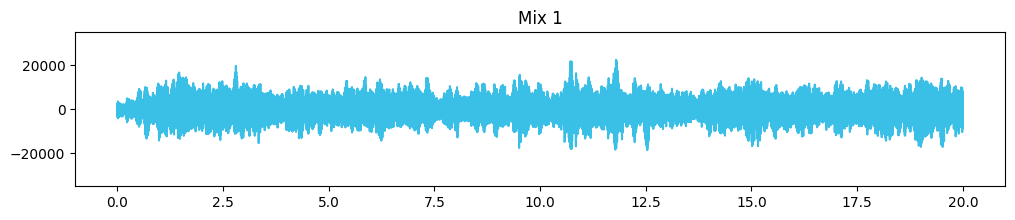

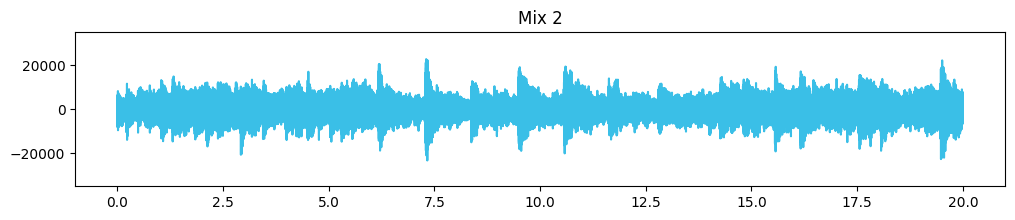

In [54]:
# plot mixed WAV files
_, ax1 = plt.subplots(figsize=(12,2))
plot_wave_arr(mix_1, title="Mix 1", ax=ax1)

_, ax2 = plt.subplots(figsize=(12,2))
plot_wave_arr(mix_2, title="Mix 2", ax=ax2)

<Axes: title={'center': 'Individual 2 (piano)'}>

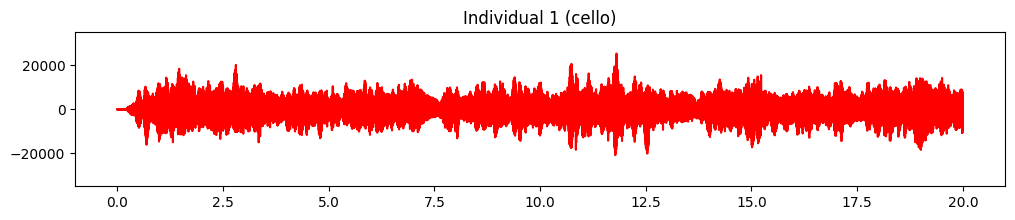

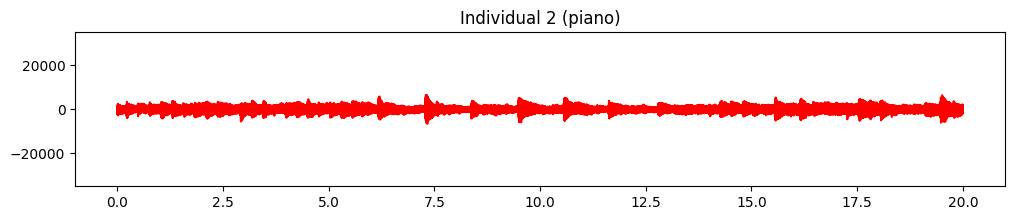

In [67]:
# plot individual WAV files
_, ax1 = plt.subplots(figsize=(12,2))
plot_wave_arr(indiv_1, title="Individual 1 (cello)", ax=ax1, color="r")

_, ax2 = plt.subplots(figsize=(12,2))
plot_wave_arr(indiv_2, title="Individual 2 (piano)", ax=ax2, color="r")

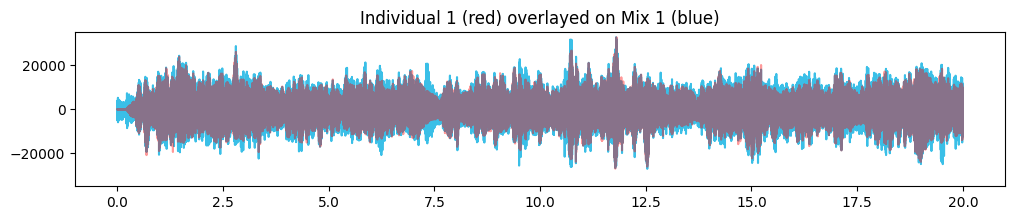

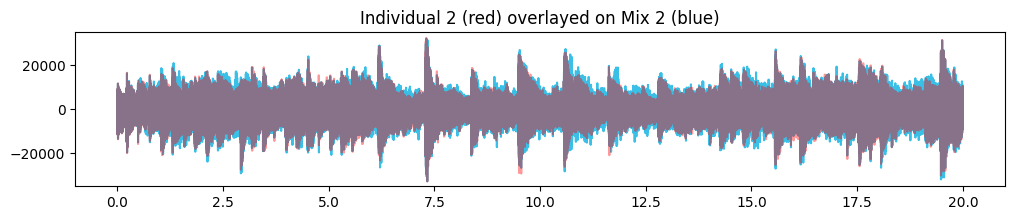

In [148]:
# overlay the individual recording on top of the mixed recording where that instrument is loudest
# NOTE: normalized data is plotted to make differences easier to see
fig, ax1 = plt.subplots(figsize=(12,2))
plot_wave_arr(norm_mix_1, ax=ax1)
plot_wave_arr(norm_indiv_1, title="Individual 1 (red) overlayed on Mix 1 (blue)", ax=ax1, color="r", alpha=0.4)
fig.savefig("output/individual-and-mixed-signal-1.png", dpi=300)

fig, ax2 = plt.subplots(figsize=(12,2))
plot_wave_arr(norm_mix_2, ax=ax2)
plot_wave_arr(norm_indiv_2, title="Individual 2 (red) overlayed on Mix 2 (blue)", ax=ax2, color="r", alpha=0.4)
fig.savefig("output/individual-and-mixed-signal-2.png", dpi=300)

## ICA

Note that in general ICA cannot determine the proper scaling (**including sign**) of the source signals.  Scaling the resulting audio files to the correct amplitude is straightforward if you scale it to fit within the bounds set by a 16 bit integer (i.e. with my `normalize_wav_arr` function).  However, proper comparison with the original individual signal may require an additional factor of -1.

>In general, ICA cannot identify the actual number of source signals, a uniquely correct ordering of the source signals, nor the proper scaling (including sign) of the source signals.
> [Wikipedia: Defining component independence](https://en.wikipedia.org/wiki/Independent_component_analysis#Defining_component_independence)

NOTE: for convenience, `random_state` has been set s.t. the resulting signal 1 corresponds to the original individual signal 1.

In [76]:
X = list(zip(mix_1, mix_2))
ica = FastICA(n_components=2, whiten="arbitrary-variance", random_state=41)
ica_result = ica.fit_transform(X)

Normalize the final results and save to file.  The normalization step is required to set the output to the WAV file scale.

In [136]:
raw_result_signal_1 = ica_result[:,0]
raw_result_signal_2 = ica_result[:,1]

# normalize the final result to the range of amplitudes defined by a 16-bit integer
result_signal_1 = normalize_wav_arr(raw_result_signal_1, 1.0)
result_signal_2 = normalize_wav_arr(raw_result_signal_2, 1.0)

# now check whether we need to multiply by a factor of -1. ICA cannot determine whether it 
# we are off by a factor of -1, but we can guess that the appropriate sign is the one that
# fits to one of mixed audio signals best.
scaling_factor_1 = determine_scaling_factor(result_signal_1, [mix_1, mix_2])
result_signal_1 = scaling_factor_1 * result_signal_1
print(f"scaling_factor_1: {scaling_factor_1}")

scaling_factor_2 = determine_scaling_factor(result_signal_2, [mix_1, mix_2])
result_signal_ = scaling_factor_2 * result_signal_2
print(f"scaling_factor_2: {scaling_factor_2}")

scaling_factor_1: -1
scaling_factor_2: 1


In [133]:
# Write results to file
print(result_file_1)
save_wave_arr(result_signal_1, result_file_1)
print(result_file_2)
save_wave_arr(result_signal_2, result_file_2)

output/deconvoluted-signal-01.wav
output/deconvoluted-signal-02.wav


## Plot results

<Axes: title={'center': 'Deconvoluted Signal 2'}>

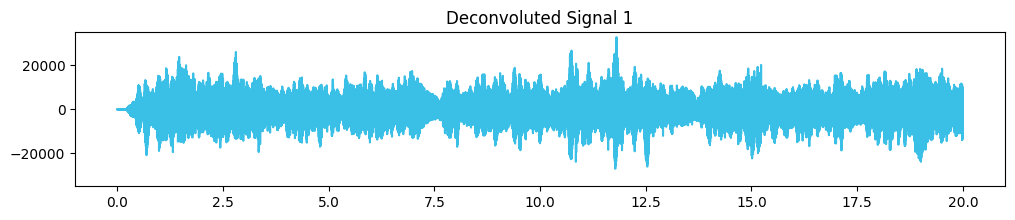

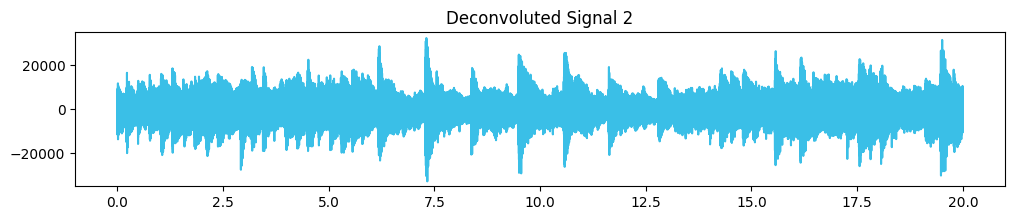

In [134]:
# plot WAV files
# NOTE: clearly the order in which signals are deconvoluted can change.  I set the random seed s.t.
# deconvoluated signal 1 matches the input individual signal 1 (cello)
_, ax1 = plt.subplots(figsize=(12,2))
plot_wave_arr(result_signal_1, title="Deconvoluted Signal 1", ax=ax1)

_, ax2 = plt.subplots(figsize=(12,2))
plot_wave_arr(result_signal_2, title="Deconvoluted Signal 2", ax=ax2)

#### Understanding deconvoluted signal

In the plots below, the deconvoluted signal is overlayed onto the corresponding original individual recording for comparison.  If deconvolution works really well, you would expect the two signals to look nearly identical, which is what we see here.  Note that if we didn't do the `determine_scaling_factor` step above, the plots *could* look significantly worse due to being off by a factor of -1.  ICA cannot determine the factor (including sign) by which the resulting signal should be scaled.

When listening to both deconvoluted files, you cannot hear any of the other instrument.

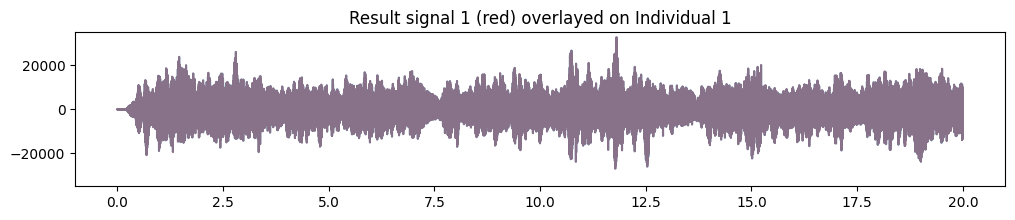

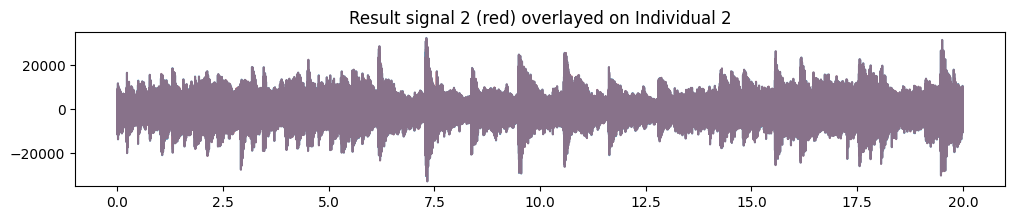

In [149]:
# overlay the deconvoluted signal onto the original signal before mixing
# NOTE: normalized data is plotted to make differences easier to see
fig, ax1 = plt.subplots(figsize=(12,2))
plot_wave_arr(norm_indiv_1, ax=ax1)
plot_wave_arr(result_signal_1, title="Result signal 1 (red) overlayed on Individual 1", ax=ax1, color="r", alpha=0.4)
fig.savefig("output/deconvoluted-and-original-signals-1.png", dpi=300)

fig, ax2 = plt.subplots(figsize=(12,2))
plot_wave_arr(norm_indiv_2, ax=ax2)
plot_wave_arr(result_signal_2, title="Result signal 2 (red) overlayed on Individual 2", ax=ax2, color="r", alpha=0.4)
fig.savefig("output/deconvoluted-and-original-signals-2.png", dpi=300)

Demonstrate what the first plot would have looked like if we had not run `determine_scaling_factor` after normalization (`scaling_factor_1 = -1` above).

<Axes: title={'center': 'Result signal 1 (red) overlayed on Individual 1'}>

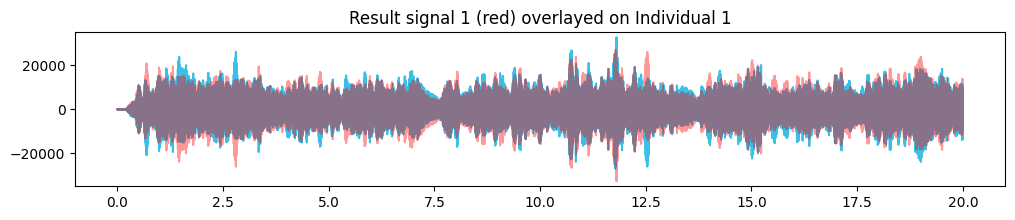

In [137]:
_, ax1 = plt.subplots(figsize=(12,2))
plot_wave_arr(norm_indiv_1, ax=ax1)
plot_wave_arr(-1.0*result_signal_1, title="Result signal 1 (red) overlayed on Individual 1", ax=ax1, color="r", alpha=0.4)

### Quantify quality of deconvolution

Build matrix with root mean squared difference comparision between
- original signal
- deconvoluted signal
- mixed signal

Visually, we can see that the deconvoluted signal looks nearly identical to the original individual signals (RMSD near zero) and the mixed signal looks significantly different from both the original and deconvoluted signals (large RMSD).

In [146]:
columns = ["orig_signal", "deconvoluted_signal", "mixed_signal"]
array_list_1 = [norm_indiv_1, result_signal_1, norm_mix_1]
comparison_matrix_1 = build_comparison_matrix(array_list_1)
comparison_df_1 = pd.DataFrame(comparison_matrix_1, columns=columns, index=columns)

array_list_2 = [norm_indiv_2, result_signal_2, norm_mix_2]
comparison_matrix_2 = build_comparison_matrix(array_list_2)
comparison_df_2 = pd.DataFrame(comparison_matrix_2, columns=columns, index=columns)

print("comparison_1")
display(comparison_df_1)
print("\ncomparison_2")
display(comparison_df_2)

comparison_1


,orig_signal,deconvoluted_signal,mixed_signal
orig_signal,0.000000,26.174542,2321.988321
deconvoluted_signal,26.174542,0.000000,2348.098661
mixed_signal,2321.988321,2348.098661,0.000000



comparison_2


,orig_signal,deconvoluted_signal,mixed_signal
orig_signal,0.000000,45.092296,2043.244731
deconvoluted_signal,45.092296,0.000000,1998.164874
mixed_signal,2043.244731,1998.164874,0.000000
